In [14]:
import gymnasium as gym
import numpy as np
import ochre_gym

# -------------------------------------------------------------
# Environment configuration
# -------------------------------------------------------------

ENV_NAME = "bldg0112631-up11"

# Observation keys selected from the OCHRE environment
OBS_KEYS = [
    "Temperature - Indoor (C)",
    "Temperature - Outdoor (C)",
    "Energy Price ($)",
    "Hour of Day",
]

# Create the base environment
env = ochre_gym.load(
    ENV_NAME,
    override_equipment_controls={"HVAC Heating": ["Setpoint"]},
    vectorize_actions=True,
    vectorize_observations=True,
    override_ochre_observations_with_keys=OBS_KEYS,

    # Episode settings
    start_time="2018-01-01 00:00:00",
    episode_duration="31 days",
    time_res="00:30",
    lookahead="12:00",

    # Demand response configuration
    dr_type="TOU",
    dr_subfolder="basic-v0",
    tou_price_file="time_of_use_price.csv",

    # Comfort constraints and reward scaling
    thermal_comfort_band_low=20.0,
    thermal_comfort_band_high=23.0,
    thermal_comfort_unit_penalty=10.0,
    reward_scale=1.0,

    # Logging options
    log_to_file=False,
    log_to_console=False,
)

# -------------------------------------------------------------
# Discrete action mapping
# -------------------------------------------------------------
# Heating setpoints will range from 20.0 to 23.0 °C in 0.5 °C increments
SETPOINTS = np.round(np.arange(20.0, 23.0 + 0.001, 0.5), 1)  # [20.0, 20.5, ..., 23.0]
A = len(SETPOINTS)


class HeatingSetpointDiscrete(gym.ActionWrapper):
    """
    Action wrapper that maps a discrete action index to a continuous
    heating setpoint (required by OCHRE). Each index corresponds to a
    temperature in the SETPOINTS array.
    """

    def __init__(self, env, setpoints: np.ndarray):
        super().__init__(env)
        self.setpoints = np.asarray(setpoints, dtype=np.float32)

        # Replace the action space with a discrete space of the same size
        self.action_space = gym.spaces.Discrete(self.setpoints.size)

    def action(self, a_idx: int) -> np.ndarray:
        """
        Convert a discrete index into the continuous setpoint expected
        by the environment.
        """
        return np.array([self.setpoints[a_idx]], dtype=np.float32)


# Wrap the environment so the agent outputs discrete setpoint indices
env = HeatingSetpointDiscrete(env, SETPOINTS)

Properties file weather station (G0800310) may be different from weather file used: C:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.


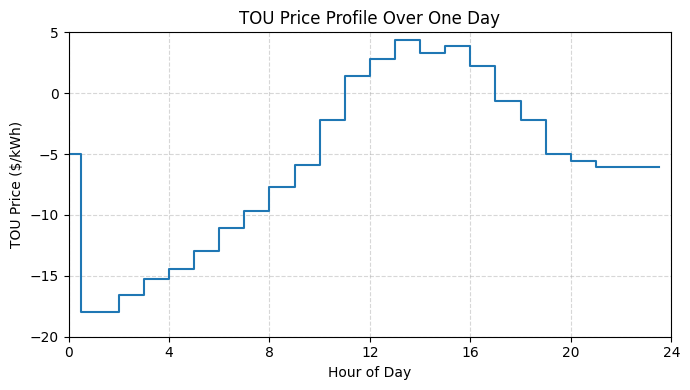

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# Collect TOU price for the first 24 hours
# -------------------------------------------------------------

obs, info = env.reset()

hours = []
prices = []

for t in range(48):  # 24 hours @ 30-min resolution
    # obs structure: [Tin, Tout, Price]
    obs_arr = np.asarray(obs).ravel()
    price = float(obs_arr[2])  # Energy Price ($)

    # Extract hour from info["Datetime"]
    dt = info.get("Datetime", None)
    if isinstance(dt, str):
        dt = pd.to_datetime(dt)

    if dt is not None:
        hour = dt.hour + dt.minute / 60.0
    else:
        # fallback: assume 30-min steps from midnight
        hour = 0.5 * t

    prices.append(price)
    hours.append(hour)

    # Take any action; price does not depend on action
    obs, reward, terminated, truncated, info = env.step(0)
    if terminated or truncated:
        break

# Sort points by time (just in case)
hours = np.array(hours)
prices = np.array(prices)
idx = np.argsort(hours)
hours = hours[idx]
prices = prices[idx]

# -------------------------------------------------------------
# Plot TOU price profile
# -------------------------------------------------------------
plt.figure(figsize=(7, 4))
plt.step(hours, prices, where="post")

# Axis formatting
plt.xlim(0, 24)
plt.xticks(np.arange(0, 25, 4))  # 0, 4, 8, ..., 24
plt.ylim(-20, 5)

plt.xlabel("Hour of Day")
plt.ylabel("TOU Price ($/kWh)")
plt.title("TOU Price Profile Over One Day")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [19]:
import numpy as np

# -------------------------------------------------------------
# Bin definitions per feature (can be tuned)
# -------------------------------------------------------------
# Indoor temperature bins: 18.0–26.5 °C in 0.5 °C increments
TIN_BINS = np.arange(18.0, 26.5, 0.5)

# Outdoor temperature bins: −20–45 °C in 5 °C increments
TOUT_BINS = np.arange(-20.0, 45.0, 5.0)

# TOU price bins ($/kWh): representative price tiers
PRICE_BINS = np.array([0.0, 0.1, 0.2, 0.4, 1.0, 5.0])

# Hour-of-day bins: 0–24 h in 3 h increments
HOUR_BINS = np.arange(0.0, 24.0 + 1e-6, 3.0)  # [0, 3, 6, ..., 24]

# Group all bin edges in a fixed order:
# [Tin, Tout, Price, Hour]
BIN_EDGES = [TIN_BINS, TOUT_BINS, PRICE_BINS, HOUR_BINS]


def discretize(obs_vec: np.ndarray) -> tuple[int, int, int, int]:
    """
    Map a continuous observation vector into a tuple of discrete bin indices.

    Expected observation order:
        [Temperature - Indoor (C),
         Temperature - Outdoor (C),
         Energy Price ($),
         Hour of Day]

    Returns
    -------
    state_idx : tuple of int
        A 4-tuple of bin indices, one per feature, suitable for use as a
        dictionary key in a tabular Q-learning setting.
    """
    # Ensure obs_vec is a flat NumPy array
    obs_vec = np.asarray(obs_vec, dtype=float).ravel()
    if obs_vec.size != 4:
        raise ValueError(f"Expected 4 features, got shape {obs_vec.shape}")

    tin, tout, price, hour = obs_vec
    vals = [tin, tout, price, hour]

    idxs: list[int] = []

    for v, edges in zip(vals, BIN_EDGES):
        # np.digitize(v, edges, right=False) returns an integer in [0, len(edges)]
        # with intervals:
        #   0             : v <= edges[0]
        #   1..len(edges)-1: edges[i-1] < v <= edges[i]
        #   len(edges)    : v > edges[-1]
        i = int(np.digitize(v, edges, right=False))

        # Clamp the index to stay within [0, len(edges)].
        # This gives an "underflow" bucket 0 and an "overflow" bucket len(edges).
        i = max(0, min(i, len(edges)))
        idxs.append(i)

    # Tuples are hashable, so they can be used as keys in a Q-table dictionary.
    return tuple(idxs)


Episode 01 | steps=1488 | return=-5007.49
Episode 02 | steps=1488 | return=-4998.18
Episode 03 | steps=1488 | return=-4964.75
Episode 04 | steps=1488 | return=-4871.23
Episode 05 | steps=1488 | return=-4716.51
Episode 06 | steps=1488 | return=-4881.49
Episode 07 | steps=1488 | return=-4846.11
Episode 08 | steps=1488 | return=-4592.22
Episode 09 | steps=1488 | return=-4682.47
Episode 10 | steps=1488 | return=-4596.97
Episode 11 | steps=1488 | return=-4502.89
Episode 12 | steps=1488 | return=-4601.72
Episode 13 | steps=1488 | return=-4372.66
Episode 14 | steps=1488 | return=-4355.98
Episode 15 | steps=1488 | return=-4454.29
Episode 16 | steps=1488 | return=-4392.37
Episode 17 | steps=1488 | return=-4298.58
Episode 18 | steps=1488 | return=-4348.79
Episode 19 | steps=1488 | return=-4470.22
Episode 20 | steps=1488 | return=-4239.93
Episode 21 | steps=1488 | return=-4271.18
Episode 22 | steps=1488 | return=-4277.12
Episode 23 | steps=1488 | return=-4396.59
Episode 24 | steps=1488 | return=-

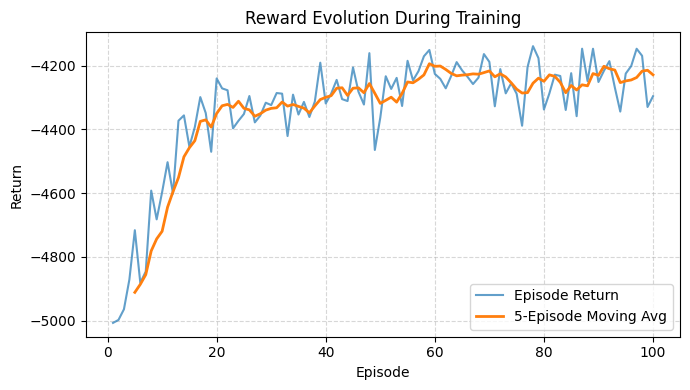

In [20]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# Helper: extract hour-of-day from env info
# -------------------------------------------------------------
def get_hour_from_info(info) -> float:
    """
    Extract hour-of-day from the environment info dictionary.

    Expected:
        info["Datetime"] is either a pandas.Timestamp or a string
        convertible via pd.to_datetime.
    """
    if not isinstance(info, dict):
        return 0.0

    dt = info.get("Datetime", None)
    if dt is None:
        return 0.0

    if isinstance(dt, str):
        dt = pd.to_datetime(dt)

    return float(dt.hour)


# -------------------------------------------------------------
# Safe discretizer (handles 3- or 4-dimensional observations)
# -------------------------------------------------------------
def discretize_safe(obs_vec, info=None) -> tuple[int, int, int, int]:
    """
    Discretize a continuous observation into bin indices.

    Expected observation order (when 4 features are present):
        [Temperature - Indoor (C),
         Temperature - Outdoor (C),
         Energy Price ($),
         Hour of Day]

    If obs_vec has only 3 entries (Tin, Tout, Price), the hour-of-day
    is inferred from `info["Datetime"]`.
    """
    obs_vec = np.asarray(obs_vec, dtype=float).ravel()

    # Add hour if missing
    if obs_vec.shape[0] == 3:
        hour = 0.0 if info is None else get_hour_from_info(info)
        obs_vec = np.concatenate([obs_vec, [hour]])
    elif obs_vec.shape[0] != 4:
        raise ValueError(f"Expected 3 or 4 features, got shape {obs_vec.shape}")

    tin, tout, price, hour = obs_vec
    vals = [tin, tout, price, hour]

    idxs: list[int] = []
    for v, edges in zip(vals, BIN_EDGES):
        # np.digitize returns integer in [0, len(edges)] with right=False
        i = int(np.digitize(v, edges, right=False))
        # Clamp to valid range to handle out-of-range values
        i = max(0, min(i, len(edges)))
        idxs.append(i)

    return tuple(idxs)


# -------------------------------------------------------------
# Q-learning hyperparameters
# -------------------------------------------------------------
alpha = 0.2                 # learning rate
gamma = 0.99                # discount factor
eps_start = 1.0             # initial epsilon (exploration)
eps_end = 0.05              # final epsilon
eps_decay = 20_000          # steps over which epsilon decays linearly
episodes = 100
max_steps = 2000

# Q-table: maps discrete state -> action-value array of length A
Q = defaultdict(lambda: np.zeros(A, dtype=np.float32))


def epsilon(step: int) -> float:
    """Linearly decay epsilon from eps_start to eps_end over eps_decay steps."""
    frac = max(0.0, 1.0 - step / eps_decay)
    return eps_end + (eps_start - eps_end) * frac


global_step = 0
ep_returns: list[float] = []  # store episode returns for plotting


# -------------------------------------------------------------
# Q-learning training loop
# -------------------------------------------------------------
for ep in range(episodes):
    obs, info = env.reset()
    s = discretize_safe(obs, info)
    ep_return = 0.0

    for t in range(max_steps):
        e = epsilon(global_step)

        # ε-greedy action selection
        if np.random.rand() < e:
            a = np.random.randint(A)       # explore
        else:
            a = int(np.argmax(Q[s]))       # exploit

        next_obs, r, terminated, truncated, info = env.step(a)
        s_next = discretize_safe(next_obs, info)

        # One-step Q-learning update
        best_next = np.max(Q[s_next])
        td_target = r + gamma * best_next
        td_error = td_target - Q[s][a]
        Q[s][a] += alpha * td_error

        s = s_next
        ep_return += r
        global_step += 1

        if terminated or truncated:
            break

    ep_returns.append(ep_return)
    print(f"Episode {ep + 1:02d} | steps={t + 1} | return={ep_return:.2f}")


# -------------------------------------------------------------
# Plot reward evolution over training
# -------------------------------------------------------------
def moving_avg(x, k: int = 5) -> np.ndarray:
    """Simple moving average with window size k."""
    if k <= 1:
        return np.asarray(x, dtype=float)

    x = np.asarray(x, dtype=float)
    w = np.ones(k) / k
    return np.convolve(x, w, mode="valid")


episodes_idx = np.arange(1, len(ep_returns) + 1)

plt.figure(figsize=(7, 4))
plt.plot(episodes_idx, ep_returns, label="Episode Return", alpha=0.7)

ma = moving_avg(ep_returns, k=5)
plt.plot(np.arange(5, len(ep_returns) + 1), ma,
         label="5-Episode Moving Avg", linewidth=2)

plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Reward Evolution During Training")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


Properties file weather station (G0800310) may be different from weather file used: C:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.
Properties file weather station (G0800310) may be different from weather file used: C:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.


=== January (training period) ===
[Eval] Episode 01 | steps=1488 | return=-4040.01
[Eval] Episode 02 | steps=1488 | return=-4040.01
[Eval] Episode 03 | steps=1488 | return=-4040.01
[Eval] Episode 01 | steps=1488 | return=-4295.78
[Eval] Episode 02 | steps=1488 | return=-4295.78
[Eval] Episode 03 | steps=1488 | return=-4295.78

=== February (unseen test period) ===
[Eval] Episode 01 | steps=336 | return=-1082.52
[Eval] Episode 02 | steps=336 | return=-1082.52
[Eval] Episode 03 | steps=336 | return=-1082.52
[Eval] Episode 01 | steps=336 | return=-1163.35
[Eval] Episode 02 | steps=336 | return=-1163.35
[Eval] Episode 03 | steps=336 | return=-1163.35

January (seen):
  RL:        total=-4040.01, steps=1488, return/step=-2.715
  Baseline:  total=-4295.78, steps=1488, return/step=-2.887
  Improvement (RL − Baseline) in return/step: 0.172
  Improvement in percentage (per-step reward): 5.95%

February (unseen):
  RL:        total=-1082.52, steps=336, return/step=-3.222
  Baseline:  total=-1163

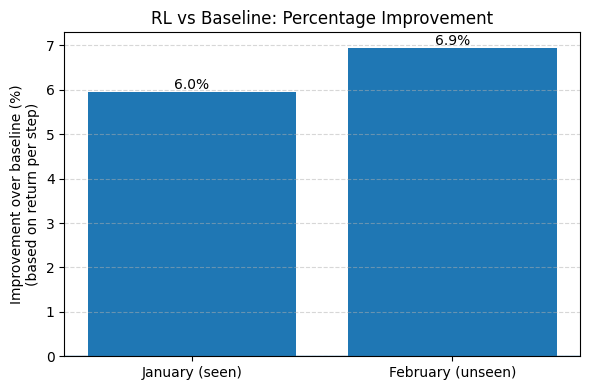

In [25]:
import numpy as np

# -------------------------------------------------------------
# Helper: fixed-setpoint baseline action index
# -------------------------------------------------------------
def get_action_index_for_setpoint(target_sp: float, setpoints: np.ndarray) -> int:
    """Return the discrete action index closest to the given setpoint."""
    return int(np.argmin(np.abs(setpoints - target_sp)))


# -------------------------------------------------------------
# Generic evaluator: RL (greedy) vs baseline (fixed setpoint)
# -------------------------------------------------------------
def evaluate_controller(env,
                        Q,
                        setpoints,
                        baseline_sp: float | None = None,
                        episodes: int = 3,
                        max_steps: int = 5000) -> dict:
    """
    Evaluate a controller on the given environment.

    If baseline_sp is None:
        use greedy RL policy: a = argmax_a Q[s, a]

    If baseline_sp is not None:
        use a fixed-setpoint baseline: a = idx closest to baseline_sp.

    Returns a dict with mean total return, mean steps, and mean return per step.
    """
    totals = []
    steps_list = []

    if baseline_sp is not None:
        baseline_idx = get_action_index_for_setpoint(baseline_sp, setpoints)

    for ep in range(episodes):
        obs, info = env.reset()
        s = discretize_safe(obs, info)
        ep_total = 0.0
        ep_steps = 0

        for t in range(max_steps):
            if baseline_sp is None:
                # RL controller: greedy action
                a = int(np.argmax(Q[s]))
            else:
                # Baseline controller: fixed action
                a = baseline_idx

            obs, r, terminated, truncated, info = env.step(a)
            s = discretize_safe(obs, info)
            ep_total += r
            ep_steps += 1

            if terminated or truncated:
                break

        totals.append(ep_total)
        steps_list.append(ep_steps)
        print(
            f"[Eval] Episode {ep+1:02d} | steps={ep_steps} | return={ep_total:.2f}"
        )

    mean_return = float(np.mean(totals))
    mean_steps = float(np.mean(steps_list))
    mean_return_per_step = mean_return / mean_steps

    return {
        "mean_return": mean_return,
        "mean_steps": mean_steps,
        "mean_return_per_step": mean_return_per_step,
    }


# -------------------------------------------------------------
# Create environments for Jan (train) and Feb (test)
# -------------------------------------------------------------
env_jan = make_env("2018-01-01 00:00:00", "31 days")
env_feb = make_env("2018-02-01 00:00:00", "7 days")

# -------------------------------------------------------------
# Evaluate controllers
# -------------------------------------------------------------
print("=== January (training period) ===")
jan_rl   = evaluate_controller(env_jan, Q, SETPOINTS, baseline_sp=None)
jan_base = evaluate_controller(env_jan, Q, SETPOINTS, baseline_sp=21.0)

print("\n=== February (unseen test period) ===")
feb_rl   = evaluate_controller(env_feb, Q, SETPOINTS, baseline_sp=None)
feb_base = evaluate_controller(env_feb, Q, SETPOINTS, baseline_sp=21.0)

# -------------------------------------------------------------
# Summarize comparisons (use return per step as main metric)
# -------------------------------------------------------------
def summarize(name, rl_stats, base_stats):
    print(f"\n{name}:")
    print(f"  RL:        total={rl_stats['mean_return']:.2f}, "
          f"steps={rl_stats['mean_steps']:.0f}, "
          f"return/step={rl_stats['mean_return_per_step']:.3f}")
    print(f"  Baseline:  total={base_stats['mean_return']:.2f}, "
          f"steps={base_stats['mean_steps']:.0f}, "
          f"return/step={base_stats['mean_return_per_step']:.3f}")

    improvement = rl_stats['mean_return_per_step'] - base_stats['mean_return_per_step']
    pct_improvement = 100.0 * improvement / abs(base_stats['mean_return_per_step'])

    print(f"  Improvement (RL − Baseline) in return/step: {improvement:.3f}")
    print(f"  Improvement in percentage (per-step reward): {pct_improvement:.2f}%")

summarize("January (seen)", jan_rl, jan_base)
summarize("February (unseen)", feb_rl, feb_base)


# -------------------------------------------------------------
# Plot percentage improvements for Jan and Feb
# -------------------------------------------------------------
import matplotlib.pyplot as plt

def compute_pct_imp(rl_stats, base_stats) -> float:
    improvement = rl_stats['mean_return_per_step'] - base_stats['mean_return_per_step']
    return 100.0 * improvement / abs(base_stats['mean_return_per_step'])

jan_pct = compute_pct_imp(jan_rl, jan_base)
feb_pct = compute_pct_imp(feb_rl, feb_base)

labels = ["January (seen)", "February (unseen)"]
values = [jan_pct, feb_pct]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, values)

# Add text labels on top of bars
for bar, val in zip(bars, values):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0,
             h,
             f"{val:.1f}%",
             ha="center",
             va="bottom")

plt.axhline(0.0, linewidth=1.0)
plt.ylabel("Improvement over baseline (%)\n(based on return per step)")
plt.title("RL vs Baseline: Percentage Improvement")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


Properties file weather station (G0800310) may be different from weather file used: C:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.


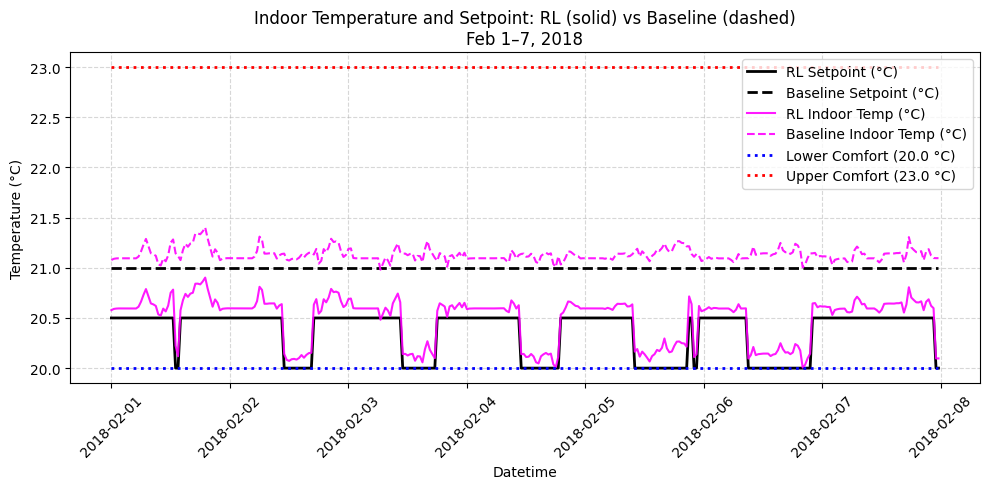

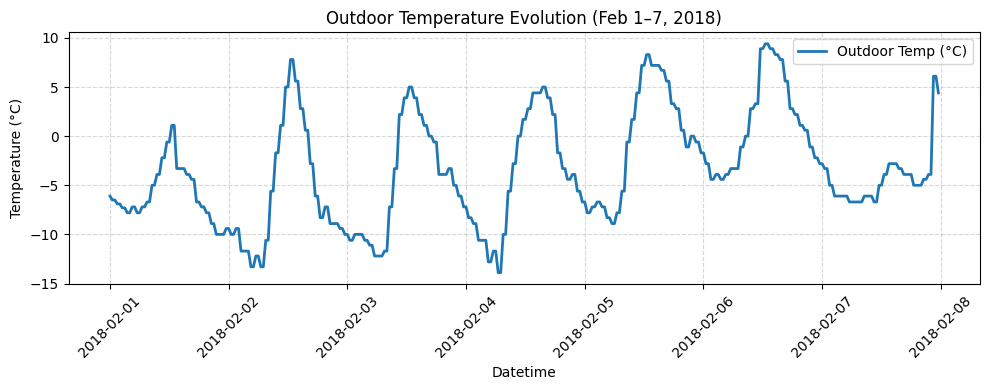

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===========================
# Helpers
# ===========================
def safe_datetime(info, t, start="2018-02-01", minutes=30):
    """
    Return a datetime for the current timestep.

    Prefer info["Datetime"] if present; otherwise fall back to
    start + t * minutes (used only as a fallback).

    Here, 'start' is set to 2018-02-01 to match the first week of February.
    """
    dt = info.get("Datetime", None) if isinstance(info, dict) else None
    if dt is None:
        return pd.Timestamp(start) + pd.Timedelta(minutes=minutes * t)
    if isinstance(dt, str):
        dt = pd.to_datetime(dt)
    return dt


def extract_indoor_temp(obs, info):
    """Extract indoor temperature, preferring info over obs vector."""
    if isinstance(info, dict) and ("Temperature - Indoor (C)" in info):
        return float(info["Temperature - Indoor (C)"])
    obs = np.asarray(obs).ravel()
    return float(obs[0])


def extract_outdoor_temp(obs, info):
    """Extract outdoor temperature, preferring info over obs vector."""
    if isinstance(info, dict) and ("Temperature - Outdoor (C)" in info):
        return float(info["Temperature - Outdoor (C)"])
    obs = np.asarray(obs).ravel()
    return float(obs[1]) if obs.size >= 2 else np.nan


def extract_obs_components(obs):
    """
    Extract (Tin, Tout, Price, Hour) from observation vector.

    Assumes override order: [Tin, Tout, Price, Hour] but falls back gracefully
    if fewer components are present.
    """
    obs = np.asarray(obs).ravel()
    tin   = float(obs[0]) if obs.size >= 1 else np.nan
    tout  = float(obs[1]) if obs.size >= 2 else np.nan
    price = float(obs[2]) if obs.size >= 3 else np.nan
    hour  = float(obs[3]) if obs.size >= 4 else np.nan
    return tin, tout, price, hour


def get_comfort_band(env, default=(20.0, 23.0)):
    """
    Try to read the thermal comfort band from the environment or its inner env.
    """
    for obj in (env, getattr(env, "env", None)):
        if obj is None:
            continue
        for attr in ("thermal_comfort_band", "comfort_band", "comfort_range"):
            if hasattr(obj, attr):
                band = getattr(obj, attr)
                if isinstance(band, (list, tuple)) and len(band) == 2:
                    return float(band[0]), float(band[1])
    return default


# ===========================
# Evaluations with action logging
# ===========================
def evaluate_policy_with_actions(env, Q, SETPOINTS, max_steps=2000):
    """
    Run the RL controller (greedy policy) and log setpoints and temperatures.
    """
    data = []
    obs, info = env.reset()
    s = discretize_safe(obs, info)

    for t in range(max_steps):
        a = int(np.argmax(Q[s]))  # greedy RL action
        obs, r, terminated, truncated, info = env.step(a)
        s = discretize_safe(obs, info)

        tin, tout, price, hour = extract_obs_components(obs)

        data.append(
            {
                "Datetime": safe_datetime(info, t),
                "ActionIdx_RL": a,
                "Setpoint_RL": float(SETPOINTS[a]),
                "IndoorTemp_RL": extract_indoor_temp(obs, info),
                "OutdoorTemp_RL": extract_outdoor_temp(obs, info),
                "Tout": tout,
                "Price": price,
                "Hour": hour,
            }
        )

        if terminated or truncated:
            break

    return pd.DataFrame(data)


def evaluate_baseline(env, SETPOINTS, fixed_setpoint=21.0, max_steps=2000):
    """
    Run a fixed-setpoint baseline controller and log setpoints and temperatures.
    """
    data = []
    fixed_idx = int(np.argmin(np.abs(np.asarray(SETPOINTS) - fixed_setpoint)))
    obs, info = env.reset()

    for t in range(max_steps):
        obs, r, terminated, truncated, info = env.step(fixed_idx)

        tin, tout, price, hour = extract_obs_components(obs)

        data.append(
            {
                "Datetime": safe_datetime(info, t),
                "ActionIdx_Base": fixed_idx,
                "Setpoint_Baseline": float(SETPOINTS[fixed_idx]),
                "IndoorTemp_Baseline": extract_indoor_temp(obs, info),
                "OutdoorTemp_Base": extract_outdoor_temp(obs, info),
                "Tout": tout,
                "Price": price,
                "Hour": hour,
            }
        )

        if terminated or truncated:
            break

    return pd.DataFrame(data)


# ===========================
# Run for the FIRST WEEK OF FEBRUARY and align
# ===========================
# New evaluation environment: Feb 1–7, 2018
env_feb = make_env("2018-02-01 00:00:00", "7 days")

rl_df   = evaluate_policy_with_actions(env_feb, Q, SETPOINTS)
base_df = evaluate_baseline(env_feb, SETPOINTS, fixed_setpoint=21.0)

merged = pd.merge_asof(
    rl_df.sort_values("Datetime"),
    base_df.sort_values("Datetime"),
    on="Datetime",
    direction="nearest",
)

# Comfort band from environment
COMFORT_LOW, COMFORT_HIGH = get_comfort_band(env_feb)


# ===========================
# Figure 1: Indoor temperature and setpoints (RL vs Baseline)
# ===========================
plt.figure(figsize=(10, 5))

plt.plot(
    merged["Datetime"],
    merged["Setpoint_RL"],
    color="black",
    linestyle="-",
    linewidth=2,
    label="RL Setpoint (°C)",
)
plt.plot(
    merged["Datetime"],
    merged["Setpoint_Baseline"],
    color="black",
    linestyle="--",
    linewidth=2,
    label="Baseline Setpoint (°C)",
)

plt.plot(
    merged["Datetime"],
    merged["IndoorTemp_RL"],
    color="magenta",
    linestyle="-",
    alpha=0.9,
    label="RL Indoor Temp (°C)",
)
plt.plot(
    merged["Datetime"],
    merged["IndoorTemp_Baseline"],
    color="magenta",
    linestyle="--",
    alpha=0.9,
    label="Baseline Indoor Temp (°C)",
)

plt.hlines(
    COMFORT_LOW,
    merged["Datetime"].iloc[0],
    merged["Datetime"].iloc[-1],
    colors="blue",
    linestyles=":",
    linewidth=2,
    label=f"Lower Comfort ({COMFORT_LOW} °C)",
)
plt.hlines(
    COMFORT_HIGH,
    merged["Datetime"].iloc[0],
    merged["Datetime"].iloc[-1],
    colors="red",
    linestyles=":",
    linewidth=2,
    label=f"Upper Comfort ({COMFORT_HIGH} °C)",
)

plt.xlabel("Datetime")
plt.ylabel("Temperature (°C)")
plt.title("Indoor Temperature and Setpoint: RL (solid) vs Baseline (dashed)\nFeb 1–7, 2018")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ===========================
# Figure 2: Outdoor temperature evolution for the same period
# ===========================
tout_series = merged["OutdoorTemp_RL"]

plt.figure(figsize=(10, 4))
plt.plot(merged["Datetime"], tout_series, linewidth=2, label="Outdoor Temp (°C)")
plt.xlabel("Datetime")
plt.ylabel("Temperature (°C)")
plt.title("Outdoor Temperature Evolution (Feb 1–7, 2018)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Properties file weather station (G0800310) may be different from weather file used: C:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.
Properties file weather station (G0800310) may be different from weather file used: C:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.


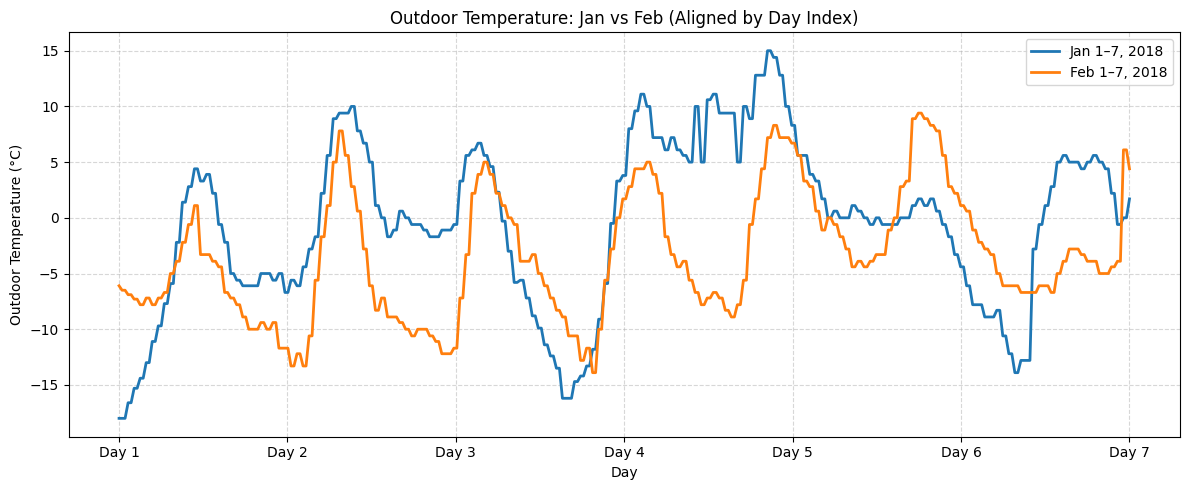

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Extract outdoor temp helper
# --------------------------
def extract_outdoor_temp(obs, info):
    if isinstance(info, dict) and ("Temperature - Outdoor (C)" in info):
        return float(info["Temperature - Outdoor (C)"])
    obs = np.asarray(obs).ravel()
    return float(obs[1]) if obs.size >= 2 else np.nan

# --------------------------
# Collect outdoor temp series
# --------------------------
def collect_week(env, start_date):
    data = []
    obs, info = env.reset()

    # 7 days × 48 half-hours = 336 steps (upper bound)
    for t in range(7 * 48):
        obs, r, terminated, truncated, info = env.step(0)
        data.append(extract_outdoor_temp(obs, info))
        if terminated or truncated:
            break

    return np.array(data)

# --------------------------
# Create 7-day envs
# --------------------------
env_jan_week1 = make_env("2018-01-01 00:00:00", "7 days")
env_feb_week1 = make_env("2018-02-01 00:00:00", "7 days")

jan_temp = collect_week(env_jan_week1, "2018-01-01")
feb_temp = collect_week(env_feb_week1, "2018-02-01")

# Make sure both arrays have same length (truncate to min if needed)
steps = min(len(jan_temp), len(feb_temp))
jan_temp = jan_temp[:steps]
feb_temp = feb_temp[:steps]

x = np.arange(steps)

# 7 day labels
days = ["Day 1", "Day 2", "Day 3", "Day 4", "Day 5", "Day 6", "Day 7"]
# 7 tick positions across the range [0, steps-1]
tick_positions = np.linspace(0, steps - 1, num=len(days))

# --------------------------
# Plot
# --------------------------
plt.figure(figsize=(12, 5))

plt.plot(x, jan_temp, label="Jan 1–7, 2018", linewidth=2)
plt.plot(x, feb_temp, label="Feb 1–7, 2018", linewidth=2)

plt.xlabel("Day")
plt.ylabel("Outdoor Temperature (°C)")
plt.title("Outdoor Temperature: Jan vs Feb (Aligned by Day Index)")
plt.xticks(tick_positions, days)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Properties file weather station (G0800310) may be different from weather file used: C:\Users\arashjkh\AppData\Local\anaconda3\envs\ochre-gym-env\lib\site-packages\ochre_gym\buildings\bldg0112631-up11\USA_CO_Denver.Intl.AP.725650_TMY3.epw
Cooling setpoint is within 1C of heating setpoint in schedule file. Separating setpoints by at least 1C.


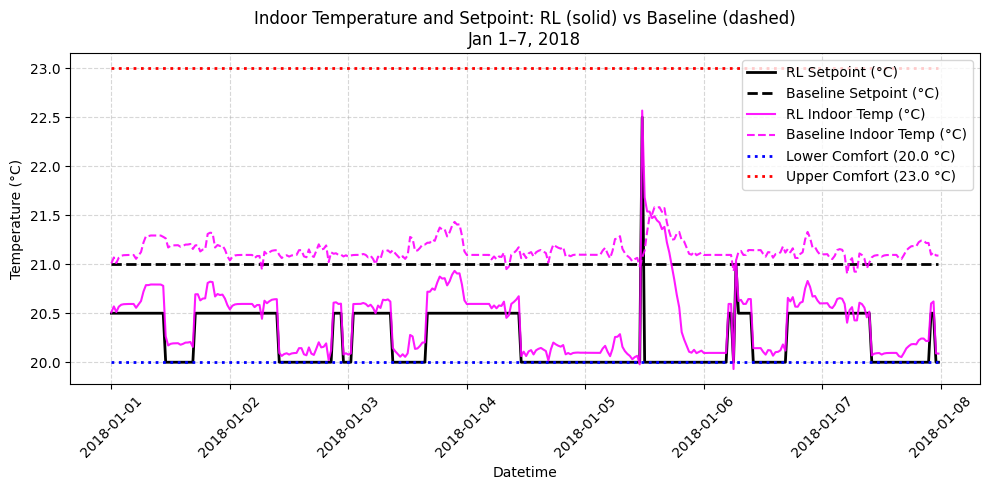

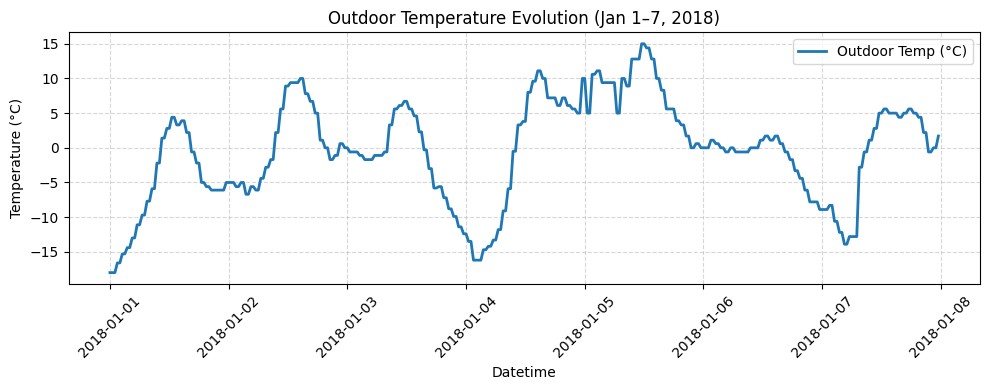

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===========================
# Helpers
# ===========================
def safe_datetime(info, t, start="2018-01-01", minutes=30):
    """
    Return a datetime for the current timestep.

    Prefer info["Datetime"] if present; otherwise fall back to
    start + t * minutes (used only as a fallback).

    Here, 'start' is set to 2018-01-01 to match the first week of January.
    """
    dt = info.get("Datetime", None) if isinstance(info, dict) else None
    if dt is None:
        return pd.Timestamp(start) + pd.Timedelta(minutes=minutes * t)
    if isinstance(dt, str):
        dt = pd.to_datetime(dt)
    return dt


def extract_indoor_temp(obs, info):
    """Extract indoor temperature, preferring info over obs vector."""
    if isinstance(info, dict) and ("Temperature - Indoor (C)" in info):
        return float(info["Temperature - Indoor (C)"])
    obs = np.asarray(obs).ravel()
    return float(obs[0])


def extract_outdoor_temp(obs, info):
    """Extract outdoor temperature, preferring info over obs vector."""
    if isinstance(info, dict) and ("Temperature - Outdoor (C)" in info):
        return float(info["Temperature - Outdoor (C)"])
    obs = np.asarray(obs).ravel()
    return float(obs[1]) if obs.size >= 2 else np.nan


def extract_obs_components(obs):
    """
    Extract (Tin, Tout, Price, Hour) from observation vector.

    Assumes override order: [Tin, Tout, Price, Hour] but falls back gracefully
    if fewer components are present.
    """
    obs = np.asarray(obs).ravel()
    tin   = float(obs[0]) if obs.size >= 1 else np.nan
    tout  = float(obs[1]) if obs.size >= 2 else np.nan
    price = float(obs[2]) if obs.size >= 3 else np.nan
    hour  = float(obs[3]) if obs.size >= 4 else np.nan
    return tin, tout, price, hour


def get_comfort_band(env, default=(20.0, 23.0)):
    """
    Try to read the thermal comfort band from the environment or its inner env.
    """
    for obj in (env, getattr(env, "env", None)):
        if obj is None:
            continue
        for attr in ("thermal_comfort_band", "comfort_band", "comfort_range"):
            if hasattr(obj, attr):
                band = getattr(obj, attr)
                if isinstance(band, (list, tuple)) and len(band) == 2:
                    return float(band[0]), float(band[1])
    return default


# ===========================
# Evaluations with action logging
# ===========================
def evaluate_policy_with_actions(env, Q, SETPOINTS, max_steps=2000):
    """
    Run the RL controller (greedy policy) and log setpoints and temperatures.
    """
    data = []
    obs, info = env.reset()
    s = discretize_safe(obs, info)

    for t in range(max_steps):
        a = int(np.argmax(Q[s]))  # greedy RL action
        obs, r, terminated, truncated, info = env.step(a)
        s = discretize_safe(obs, info)

        tin, tout, price, hour = extract_obs_components(obs)

        data.append(
            {
                "Datetime": safe_datetime(info, t),
                "ActionIdx_RL": a,
                "Setpoint_RL": float(SETPOINTS[a]),
                "IndoorTemp_RL": extract_indoor_temp(obs, info),
                "OutdoorTemp_RL": extract_outdoor_temp(obs, info),
                "Tout": tout,
                "Price": price,
                "Hour": hour,
            }
        )

        if terminated or truncated:
            break

    return pd.DataFrame(data)


def evaluate_baseline(env, SETPOINTS, fixed_setpoint=21.0, max_steps=2000):
    """
    Run a fixed-setpoint baseline controller and log setpoints and temperatures.
    """
    data = []
    fixed_idx = int(np.argmin(np.abs(np.asarray(SETPOINTS) - fixed_setpoint)))
    obs, info = env.reset()

    for t in range(max_steps):
        obs, r, terminated, truncated, info = env.step(fixed_idx)

        tin, tout, price, hour = extract_obs_components(obs)

        data.append(
            {
                "Datetime": safe_datetime(info, t),
                "ActionIdx_Base": fixed_idx,
                "Setpoint_Baseline": float(SETPOINTS[fixed_idx]),
                "IndoorTemp_Baseline": extract_indoor_temp(obs, info),
                "OutdoorTemp_Base": extract_outdoor_temp(obs, info),
                "Tout": tout,
                "Price": price,
                "Hour": hour,
            }
        )

        if terminated or truncated:
            break

    return pd.DataFrame(data)


# ===========================
# Run for the FIRST WEEK OF JANUARY and align
# ===========================
# New evaluation environment: Jan 1–7, 2018
env_jan = make_env("2018-01-01 00:00:00", "7 days")

rl_df   = evaluate_policy_with_actions(env_jan, Q, SETPOINTS)
base_df = evaluate_baseline(env_jan, SETPOINTS, fixed_setpoint=21.0)

merged = pd.merge_asof(
    rl_df.sort_values("Datetime"),
    base_df.sort_values("Datetime"),
    on="Datetime",
    direction="nearest",
)

# Comfort band from environment
COMFORT_LOW, COMFORT_HIGH = get_comfort_band(env_jan)


# ===========================
# Figure 1: Indoor temperature and setpoints (RL vs Baseline)
# ===========================
plt.figure(figsize=(10, 5))

plt.plot(
    merged["Datetime"],
    merged["Setpoint_RL"],
    color="black",
    linestyle="-",
    linewidth=2,
    label="RL Setpoint (°C)",
)
plt.plot(
    merged["Datetime"],
    merged["Setpoint_Baseline"],
    color="black",
    linestyle="--",
    linewidth=2,
    label="Baseline Setpoint (°C)",
)

plt.plot(
    merged["Datetime"],
    merged["IndoorTemp_RL"],
    color="magenta",
    linestyle="-",
    alpha=0.9,
    label="RL Indoor Temp (°C)",
)
plt.plot(
    merged["Datetime"],
    merged["IndoorTemp_Baseline"],
    color="magenta",
    linestyle="--",
    alpha=0.9,
    label="Baseline Indoor Temp (°C)",
)

plt.hlines(
    COMFORT_LOW,
    merged["Datetime"].iloc[0],
    merged["Datetime"].iloc[-1],
    colors="blue",
    linestyles=":",
    linewidth=2,
    label=f"Lower Comfort ({COMFORT_LOW} °C)",
)
plt.hlines(
    COMFORT_HIGH,
    merged["Datetime"].iloc[0],
    merged["Datetime"].iloc[-1],
    colors="red",
    linestyles=":",
    linewidth=2,
    label=f"Upper Comfort ({COMFORT_HIGH} °C)",
)

plt.xlabel("Datetime")
plt.ylabel("Temperature (°C)")
plt.title("Indoor Temperature and Setpoint: RL (solid) vs Baseline (dashed)\nJan 1–7, 2018")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ===========================
# Figure 2: Outdoor temperature evolution for the same period
# ===========================
tout_series = merged["OutdoorTemp_RL"]

plt.figure(figsize=(10, 4))
plt.plot(merged["Datetime"], tout_series, linewidth=2, label="Outdoor Temp (°C)")
plt.xlabel("Datetime")
plt.ylabel("Temperature (°C)")
plt.title("Outdoor Temperature Evolution (Jan 1–7, 2018)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
import numpy as np

# Find suspiciously high indoor temps
spike_mask = merged["IndoorTemp_RL"] > 22.5  # adjust threshold if needed

# Try to pick whatever Tout / Price columns exist
tout_cols  = [c for c in merged.columns if "Tout"  in c]
price_cols = [c for c in merged.columns if "Price" in c]

cols_to_show = ["Datetime", "IndoorTemp_RL", "Setpoint_RL"]
cols_to_show += tout_cols + price_cols

print(merged.loc[spike_mask, cols_to_show])


               Datetime  IndoorTemp_RL  Setpoint_RL     Tout_x     Tout_y  \
215 2018-01-05 11:30:00      22.567519         22.5  22.567519  21.066948   

     Price_x  Price_y  
215     15.0     15.0  
